In [1]:
import os
import pathlib
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34, mobilenet_v2
from tqdm import tqdm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import warnings
import utils as u
warnings.filterwarnings("ignore")

In [2]:
# Define paths
pascal_voc = pathlib.Path('./data/VOC2012_train_val')
image_dir = pascal_voc / 'JPEGImages'
label_dir = pascal_voc / 'SegmentationClass'
split_dir = pascal_voc / 'ImageSets' / 'Segmentation'

# Read image IDs from trainval.txt
with open(split_dir / 'trainval.txt', 'r') as f:
    image_ids = [line.strip() for line in f]

# Class names and colormap (RGB values for each class)
classes = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", 
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", 
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

voc_colormap = [
    (0, 0, 0), (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
    (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)
]

In [3]:
# Initialize dataset with augmentations
dataset = u.VOCDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    image_ids=image_ids,
    colormap=voc_colormap,
    transform=u.AugmentTransform()
)

# Create DataLoader with minimal worker configuration for stability
dataloader = DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=True, 
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    pin_memory=False  # Disable pin_memory for now

)
try:
    # Test the dataloader with a single batch
    images, labels = next(iter(dataloader))
    print(f'Image batch shape: {images.shape}')
    print(f'Label batch shape: {labels.shape}')
except Exception as e:
    print(f"Error loading data: {str(e)}")


Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8, 224, 224])


In [4]:
def compute_metrics(outputs, labels):
    # Ensure outputs and labels are on the same device
    outputs = outputs.detach()
    labels = labels.detach()

    # Ignore void class (255)
    mask = (labels != 255)
    outputs = outputs.argmax(dim=1)  # Convert logits to class indices (B, H, W)
    outputs = outputs[mask]
    labels = labels[mask]

    # Handle empty tensors (if all pixels are void)
    if outputs.numel() == 0:
        return torch.tensor(0.0).to(outputs.device), torch.tensor(0.0).to(outputs.device)

    # Pixel accuracy
    acc = (outputs == labels).float().mean()

    # Calculate IoU for each class (21 classes for VOC)
    ious = []
    n_classes = 21  # Fixed for Pascal VOC
    for cls in range(n_classes):
        pred_cls = (outputs == cls)
        target_cls = (labels == cls)
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()

        if union == 0:
            ious.append(float('nan'))  # Skip classes with no ground truth
        else:
            ious.append((intersection / union).item())

    # Compute mean IoU, ignoring NaN
    miou = np.nanmean(ious) if not np.isnan(ious).all() else 0.0

    return acc, torch.tensor(miou).to(outputs.device)

In [5]:
from sklearn.model_selection import train_test_split

# Split into train+val (80%) and test (20%)
train_val_ids, test_ids = train_test_split(
    image_ids, test_size=0.2, random_state=42
)

# Split train+val into train (80% of 80% = 64%) and val (20% of 80% = 16%)
train_ids, val_ids = train_test_split(
    train_val_ids, test_size=0.25, random_state=42  # 0.25 * 80% = 20% of original
)

# Create datasets for train, val, and test
train_dataset = u.VOCDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    image_ids=train_ids,
    colormap=voc_colormap,
    transform=u.AugmentTransform()  # Apply data augmentation to train only
)

val_dataset = u.VOCDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    image_ids=val_ids,
    colormap=voc_colormap,
    transform=None  # No augmentation for val/test (use basic preprocessing if needed)
)

test_dataset = u.VOCDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    image_ids=test_ids,
    colormap=voc_colormap,
    transform=None
)

# Create DataLoaders for all splits
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [6]:
import datetime
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np

# Define Loss Functions
loss_functions = {
    "CrossEntropy": nn.CrossEntropyLoss(ignore_index=255),
    "DiceLoss": u.DiceLoss(ignore_index=255),
    "FocalLoss": u.FocalLoss(alpha=0.25, gamma=2)
}

# Define Optimizer Configurations
optimizers_config = {
    "Adam": {
        "constructor": optim.Adam,
        "lr": 1e-4,
        "kwargs": {}
    }
}
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, device, writer=None):
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_acc, running_miou = 0.0, 0.0, 0.0
        
        # Training phase
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Apply dropout during training
            seg_output = model(images)
            loss = criterion(seg_output, labels)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            # Calculate metrics
            acc, miou = compute_metrics(seg_output, labels)
            running_loss += loss.item()
            running_acc += acc.item()
            running_miou += miou.item()

        # Validation phase
        val_loss, val_acc, val_miou = 0.0, 0.0, 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                seg_output = model(images)
                loss = criterion(seg_output, labels)
                acc, miou = compute_metrics(seg_output, labels)
                val_loss += loss.item()
                val_acc += acc.item()
                val_miou += miou.item()

        # Calculate epoch metrics
        train_loss = running_loss / len(train_loader)
        train_acc = running_acc / len(train_loader)
        train_miou = running_miou / len(train_loader)
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_miou /= len(val_loader)

        # Update learning rate
        scheduler.step(val_loss)  # Changed to use ReduceLROnPlateau

        # TensorBoard logging
        if writer:
            writer.add_scalar('Loss/Train', train_loss, epoch)
            writer.add_scalar('Loss/Val', val_loss, epoch)
            writer.add_scalar('Accuracy/Train', train_acc, epoch)
            writer.add_scalar('Accuracy/Val', val_acc, epoch)
            writer.add_scalar('mIoU/Train', train_miou, epoch)
            writer.add_scalar('mIoU/Val', val_miou, epoch)
            writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)



    return val_loss

def run_experiments():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_epochs = 10  
    
    for loss_name, criterion in loss_functions.items():
        for optim_name, optim_config in optimizers_config.items():
            timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            exp_name = f"loss_{loss_name}_optim_{optim_name}_lr{optim_config['lr']}_{timestamp}"
            
            writer = SummaryWriter(f'./tensor_board/{exp_name}')
            
            # Create model
            model = u.CustomUNet(n_classes=21).to(device)
            
            optimizer = optim_config['constructor'](
                model.parameters(),
                lr=optim_config['lr'],
                **optim_config['kwargs']
            )

            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode='min', factor=0.1, patience=5, 
                        verbose=True)

            
            print(f"\nStarting experiment: {exp_name}")
            
            final_val_loss = train_model(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler,
                num_epochs=num_epochs,
                device=device,
                writer=writer
            )
            
            writer.add_hparams(
                hparam_dict={
                    'loss': loss_name,
                    'optimizer': optim_name,
                    'lr': optim_config['lr']
                },
                metric_dict={
                    'hparam/val_loss': final_val_loss
                }
            )
            
            writer.close()
            
            model_path = f"models/{optim_name}_{loss_name}.pth"
            torch.save(model.state_dict(), model_path)
            print(f"Saved model to {model_path}")
            
            del model
            torch.cuda.empty_cache()

if __name__ == "__main__":
    run_experiments()



Starting experiment: loss_CrossEntropy_optim_Adam_lr0.0001_20250128-160413


Epoch 10/10: 100%|██████████| 221/221 [08:18<00:00,  2.26s/it]


Saved model to models/Adam_CrossEntropy.pth

Starting experiment: loss_DiceLoss_optim_Adam_lr0.0001_20250128-174914


Epoch 10/10: 100%|██████████| 221/221 [08:28<00:00,  2.30s/it]


Saved model to models/Adam_DiceLoss.pth

Starting experiment: loss_FocalLoss_optim_Adam_lr0.0001_20250128-194048


Epoch 10/10: 100%|██████████| 221/221 [08:25<00:00,  2.29s/it]


Saved model to models/Adam_FocalLoss.pth


In [11]:
torch.load("models/model_2.pth")
model = u.CustomUNet(n_classes=21)
model.load_state_dict(torch.load("models/model_2.pth"))
model.eval()


CustomUNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(ignore_index=255)
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_miou = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc, miou = compute_metrics(outputs, labels)
            
            total_loss += loss.item()
            total_acc += acc.item()
            total_miou += miou.item()
    
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)
    avg_miou = total_miou / len(dataloader)
    return avg_loss, avg_acc, avg_miou

# Run evaluation
val_loss, val_acc, val_miou = evaluate_model(model, val_loader)
print(f"Validation Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, mIoU: {val_miou:.4f}")

Evaluating: 100%|██████████| 74/74 [03:06<00:00,  2.52s/it]

Validation Loss: 0.4861, Acc: 0.8910, mIoU: 0.2700


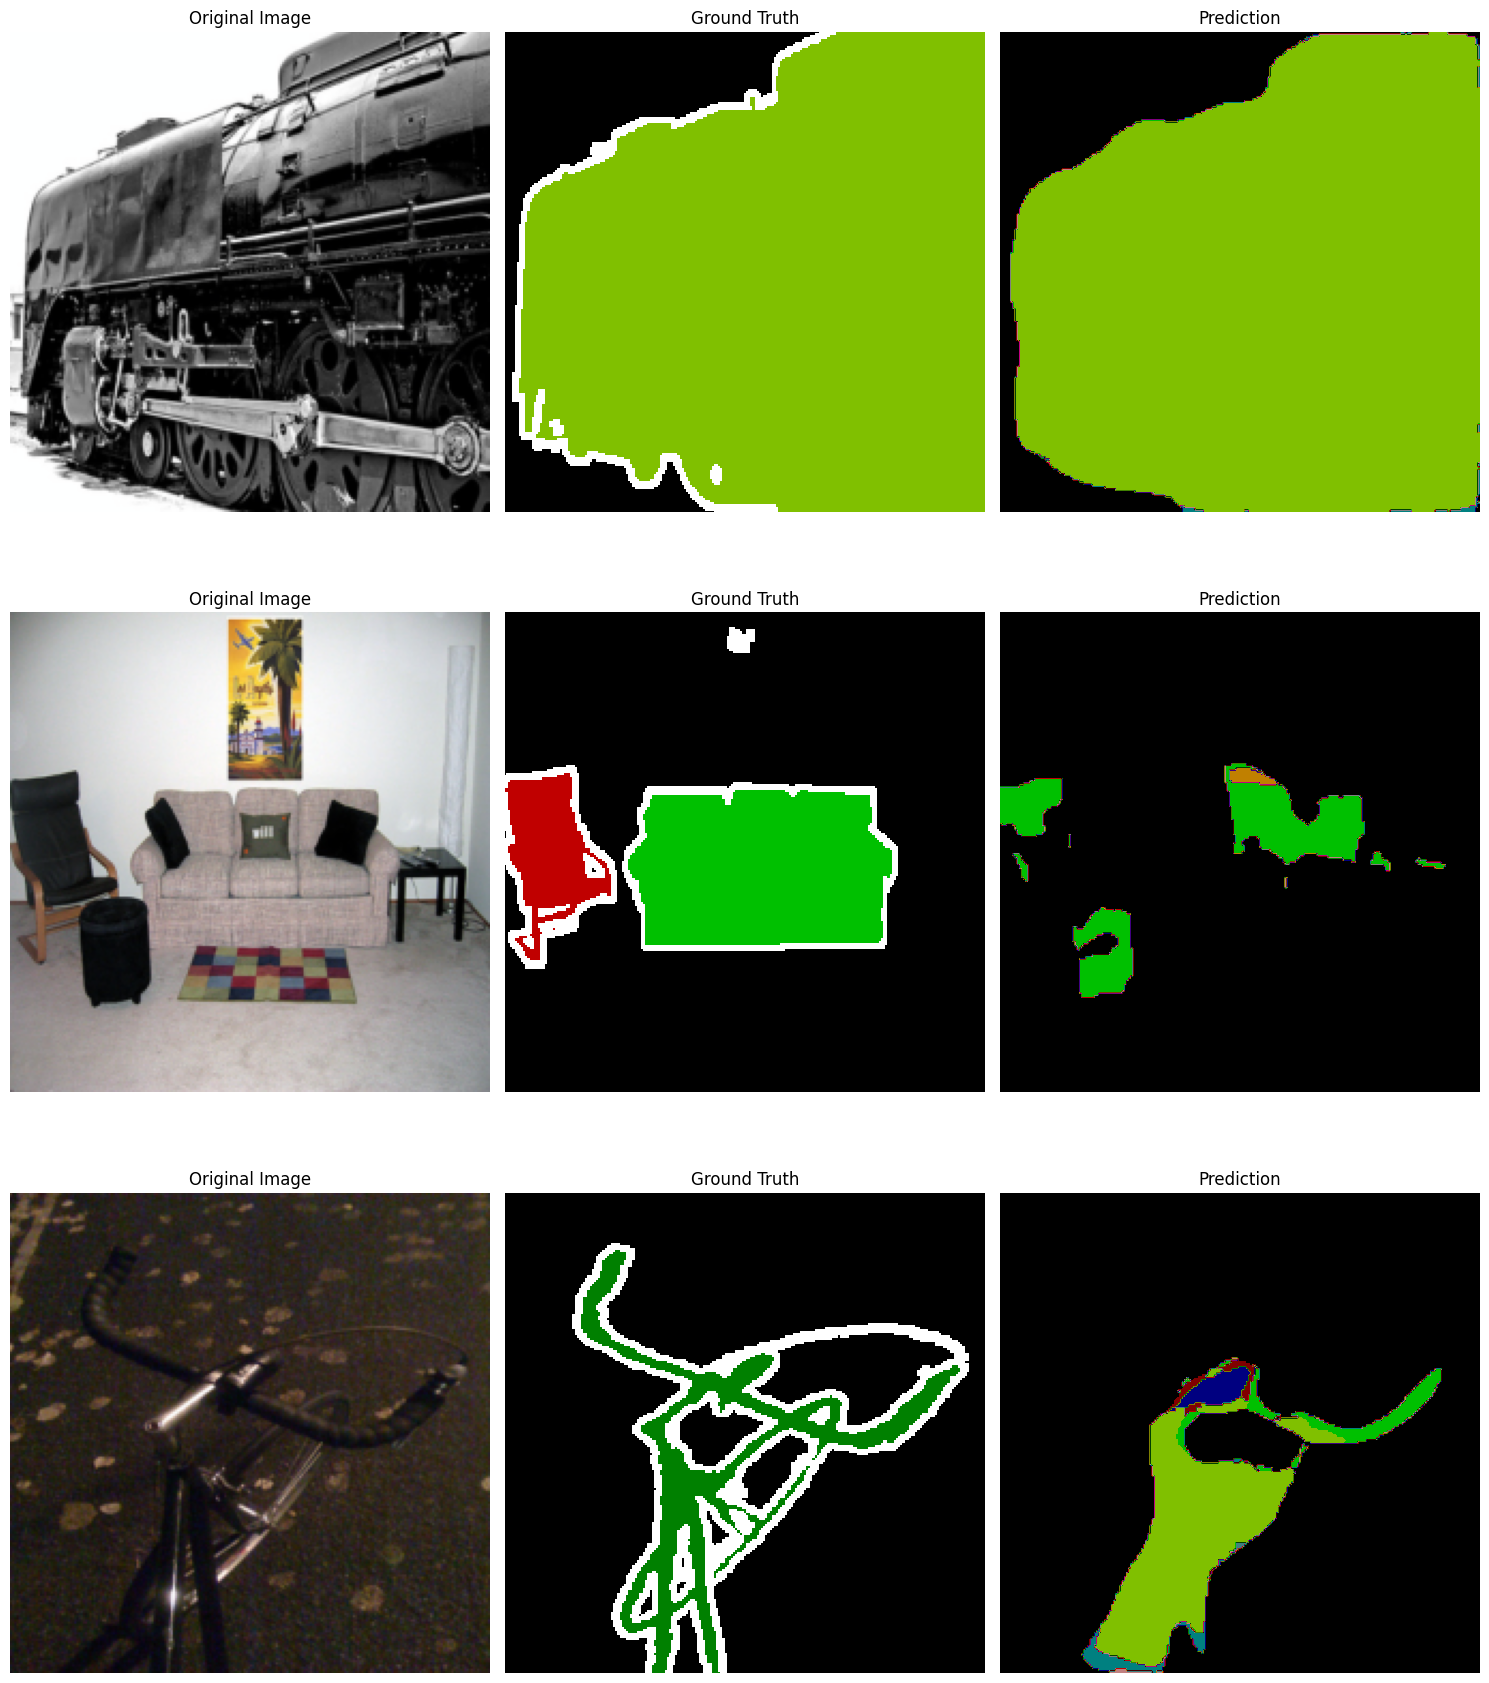

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_predictions(model, dataloader, num_samples=3, figsize=(15, 5)):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    
    with torch.no_grad():
        
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(figsize[0], figsize[1]*num_samples))
    
    # Create a custom colormap from VOC colors
    class_cmap = ListedColormap([np.array(color)/255. for color in voc_colormap])
    
    for i in range(num_samples):
        # Original image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Reverse normalization
        img = np.clip(img, 0, 1)
        
        # Ground truth
        gt = labels[i].numpy()
        gt_masked = np.ma.masked_where(gt == 255, gt)  # Mask void pixels
        
        # Prediction
        pred = preds[i]
        
        # Plot
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(gt_masked, cmap=class_cmap, vmin=0, vmax=20)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(pred, cmap=class_cmap, vmin=0, vmax=20)
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize with larger figure size
plot_predictions(model, test_loader, num_samples=3, figsize=(15, 6))